In [1]:
%pylab inline --no-import-all
import ROOT

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rootnotes
c1 = rootnotes.default_canvas()

In [3]:
%ls csv

ConvertToRoot.C                        parameterized_inc05_indexed.root?dl=0
fixed.csv                              parameterized_inc10.csv
parameterized.root                     parameterized_inc10.root
parameterized_inc05.csv.gz             parameterized_inc10_indexed.root
parameterized_inc05.root


In [8]:
f= ROOT.TFile('histograms_parameterized.root')
f.ls()

In [9]:
jesParamValues = np.linspace(5,15,11)/10
jesParamValues
jesTrueValues = [0.75, 0.9, 0.95, 0.975, 1, 1.025, 1.05, 1.1, 1.25]
jesParamValues = jesTrueValues #new file uses same points for both

In [10]:
histograms = []
i = 0
for jesTrue in jesTrueValues:
    for jesParam in jesParamValues:
        for label in [0,1]:
            title = 'h_%.3f_%.3f_%d' %(jesTrue, jesParam,label)
            print i, title
            h = f.Get(title)
            histograms.append(h)
            i+=1


0 h_0.750_0.750_0
1 h_0.750_0.750_1
2 h_0.750_0.900_0
3 h_0.750_0.900_1
4 h_0.750_0.950_0
5 h_0.750_0.950_1
6 h_0.750_0.975_0
7 h_0.750_0.975_1
8 h_0.750_1.000_0
9 h_0.750_1.000_1
10 h_0.750_1.025_0
11 h_0.750_1.025_1
12 h_0.750_1.050_0
13 h_0.750_1.050_1
14 h_0.750_1.100_0
15 h_0.750_1.100_1
16 h_0.750_1.250_0
17 h_0.750_1.250_1
18 h_0.900_0.750_0
19 h_0.900_0.750_1
20 h_0.900_0.900_0
21 h_0.900_0.900_1
22 h_0.900_0.950_0
23 h_0.900_0.950_1
24 h_0.900_0.975_0
25 h_0.900_0.975_1
26 h_0.900_1.000_0
27 h_0.900_1.000_1
28 h_0.900_1.025_0
29 h_0.900_1.025_1
30 h_0.900_1.050_0
31 h_0.900_1.050_1
32 h_0.900_1.100_0
33 h_0.900_1.100_1
34 h_0.900_1.250_0
35 h_0.900_1.250_1
36 h_0.950_0.750_0
37 h_0.950_0.750_1
38 h_0.950_0.900_0
39 h_0.950_0.900_1
40 h_0.950_0.950_0
41 h_0.950_0.950_1
42 h_0.950_0.975_0
43 h_0.950_0.975_1
44 h_0.950_1.000_0
45 h_0.950_1.000_1
46 h_0.950_1.025_0
47 h_0.950_1.025_1
48 h_0.950_1.050_0
49 h_0.950_1.050_1
50 h_0.950_1.100_0
51 h_0.950_1.100_1
52 h_0.950_1.250_0
53 

In [11]:
len(histograms)

162

In [12]:
opt = ''
for i in range(99):
    histograms[2*i+1].Draw(opt)
    opt = 'same'
c1

IndexError: list index out of range

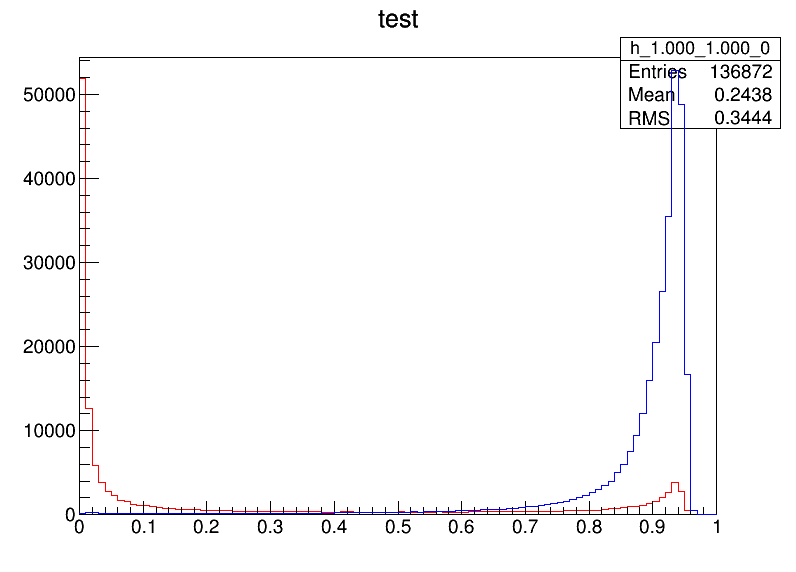

In [9]:
histograms[98].SetLineColor(ROOT.kRed)
histograms[99].SetLineColor(ROOT.kBlue)

histograms[98].Draw()
histograms[99].Draw('same')
c1

In [13]:
def getHist(jesTrue, jesParam, label):
    title = 'h_%.3f_%.3f_%d' %(jesTrue, jesParam,label)
    h = f.Get(title)
    return h

In [57]:
#setup some variables
#nn = ROOT.RooRealVar('nn','',0,1)
nn = ROOT.RooRealVar('nn','',0,.1)
nnvarList = ROOT.RooArgList(nn)
nnvarSet = ROOT.RooArgSet(nn)
sigFrac = ROOT.RooRealVar('sigFrac','',0,1)
bkgYield = ROOT.RooRealVar('bkgYield','',0,1000000)
sigYield = ROOT.RooRealVar('sigYield','',0,1000000)
yieldList = ROOT.RooArgList(sigYield,bkgYield)

In [48]:
#make asimov data based on JES=1
hbkg_asimov = getHist(1.,1.,0)
hsig_asimov = getHist(1.,1.,1)
#background 	    xs = 104 pb, eff = 0.0691
#signal (M=1TeV) xs = 0.32 p  , eff = 0.08655
sigNorm = 0.32*0.08655*30000/hsig_asimov.GetEntries()
bkgNorm = 104.*0.0691*30000/hbkg_asimov.GetEntries()

print sigNorm, bkgNorm, sigNorm/(sigNorm+bkgNorm)
hasimov = ROOT.TH1F('hasimov','',100,0,1)
hasimov.Add(hbkg_asimov,hsig_asimov,bkgNorm,sigNorm)

asimov_data = ROOT.RooDataHist('asimov_data','',nnvarList,hasimov)
sig_data = ROOT.RooDataHist('sig_data','',nnvarList,hsig_asimov)
bkg_data = ROOT.RooDataHist('bkg_data','',nnvarList,hbkg_asimov)
asimov_data.Print('v')


0.002726485181 1.57513589339 0.00172796133429


In [69]:
def fitWithJes(jes,nnframe,sigFracFrame,color):
    hbkg_asimov = getHist(1.,jes,0)
    hsig_asimov = getHist(1.,jes,1)
    #background 	    xs = 104 pb, eff = 0.0691
    #signal (M=1TeV) xs = 0.32 p  , eff = 0.08655
    lumi = 10000. #pb
    sigNorm = 0.32*0.08655*lumi/hsig_asimov.GetEntries()
    bkgNorm = 104.*0.0691*lumi/hbkg_asimov.GetEntries()
    #sigNorm = .001
    #bkgNorm = .001


    print sigNorm, bkgNorm, sigNorm/(sigNorm+bkgNorm)
    hasimov = ROOT.TH1F('hasimov','',100,0,1)
    hasimov.Add(hbkg_asimov,hsig_asimov,bkgNorm,sigNorm)

    asimov_data = ROOT.RooDataHist('asimov_data','',nnvarList,hasimov)
    sig_data = ROOT.RooDataHist('sig_data','',nnvarList,hsig_asimov)
    bkg_data = ROOT.RooDataHist('bkg_data','',nnvarList,hbkg_asimov)
    asimov_data.Print('v')

    # make model
    hbkg = getHist(jes,jes,0)
    hsig = getHist(jes,jes,1)
    print hsig.GetName()
    print '\n\n\n sig/bkg =', hsig.GetEntries()/ hbkg.GetEntries()
    sig_temp = ROOT.RooDataHist('sig_data','',nnvarList,hsig)
    bkg_temp = ROOT.RooDataHist('bkg_data','',nnvarList,hbkg)
    sig_pdf = ROOT.RooHistPdf('sig_pdf','',nnvarSet,sig_temp)
    bkg_pdf = ROOT.RooHistPdf('bkg_pdf','',nnvarSet,bkg_temp)
    # model with signal fraction, not extended
    model = ROOT.RooAddPdf('model','',sig_pdf,bkg_pdf,sigFrac)
    #model with extended pdf
    #pdfList = ROOT.RooArgList(sig_pdf,bkg_pdf)
    #model = ROOT.RooAddPdf('model','',pdfList,yieldList)
    model.fitTo(asimov_data)
    asimov_data.plotOn(nnframe)
    model.plotOn(nnframe,ROOT.RooFit.LineColor(color))

    nll = model.createNLL(asimov_data)
    nllmin = nll.getVal()
    nll.plotOn(sigFracFrame,ROOT.RooFit.LineColor(color))
    return nllmin
    

0.000908828393668 0.525045297796 0.00172796133429
h_1.000_1.000_1



 sig/bkg = 2.22648898241
0.000908828393668 0.525045297796 0.00172796133429
h_0.975_0.975_1



 sig/bkg = 2.22648898241
0.000908828393668 0.525045297796 0.00172796133429
h_0.950_0.950_1



 sig/bkg = 2.22648898241
nll -143406.991999 -128493.744514


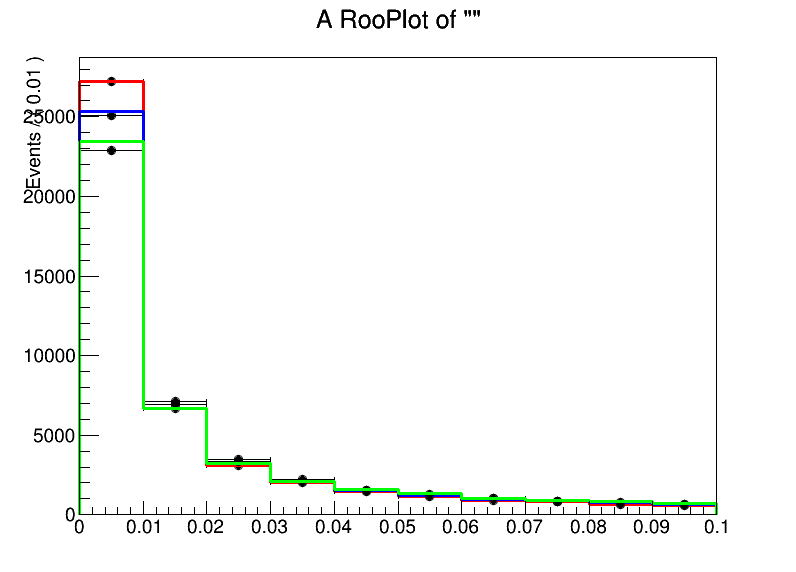

In [70]:
nnframe = nn.frame()
sigFracFrame = sigFrac.frame(0,.1)


nllMin = fitWithJes(1.,nnframe, sigFracFrame,ROOT.kRed)
nllMin9 = fitWithJes(.975,nnframe, sigFracFrame,ROOT.kBlue)
nllMin9 = fitWithJes(.95,nnframe, sigFracFrame,ROOT.kGreen)

nnframe.Draw()
c1.SetLogy(False)
print 'nll',nllMin, nllMin9
c1



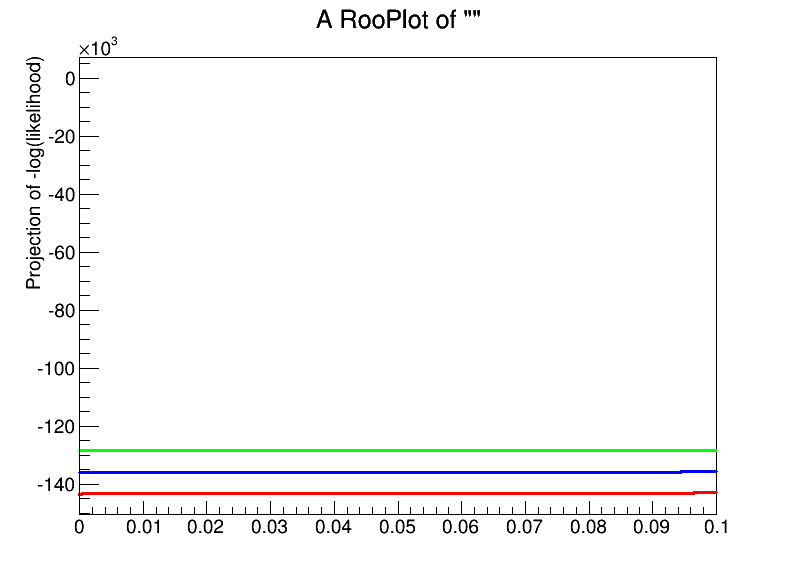

In [71]:
#sigFracFrame.SetMinimum(nllMin)
#sigFracFrame.SetMaximum(nllMin+10)
sigFracFrame.Draw()
c1.SetLogy(False)

c1

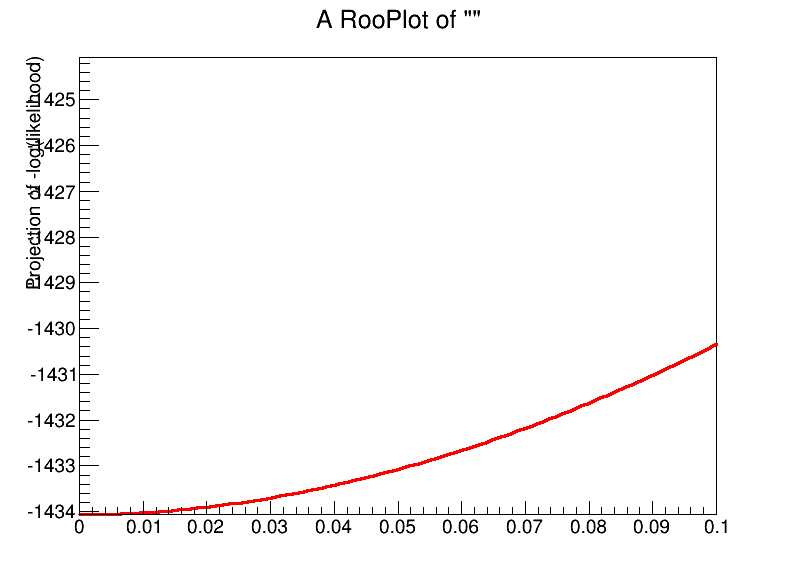

In [52]:

sigFracFrame.SetMinimum(nllMin)
sigFracFrame.SetMaximum(nllMin+10)
#sigFracFrame.Draw()

c1

0.000908828393668 0.525045297796 0.00172796133429
h_1.000_1.000_1



 sig/bkg = 2.22648898241
0.000908828393668 0.525045297796 0.00172796133429
h_0.975_0.975_1



 sig/bkg = 2.22648898241


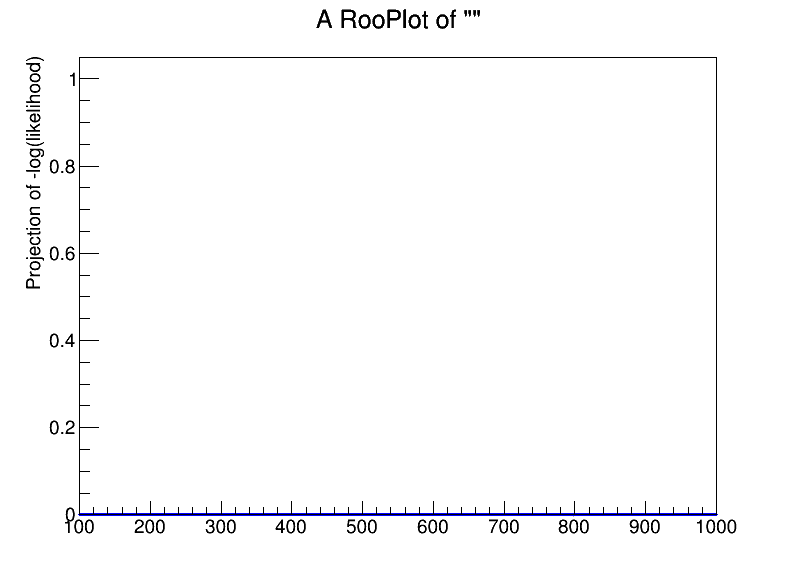

In [64]:
#run for extended pdf fit
nnframe = nn.frame()
sigYieldFrame = sigFrac.frame(100,1000)


nllMin = fitWithJes(1.,nnframe, sigYieldFrame,ROOT.kRed)
nllMin9 = fitWithJes(.975,nnframe, sigYieldFrame,ROOT.kBlue)

sigYieldFrame.Draw()
c1.SetLogy(False)
c1

In [158]:
asimov_data.Print()

In [111]:
sigFrac.setVal(0)
nllat0 = nll.getVal()
sigFrac.setVal(7.10742e-01)
nllatmin = nll.getVal()
print nllat0-nllatmin

3554.89826226


from fit with jes=1

sigFrac.setVal(0)
nllat0 = nll.getVal()
sigFrac.setVal(6.48752e-02)
nllatmin = nll.getVal()
print nllat0-nllatmin
2.86345250519

In [129]:
sigFrac.frame?

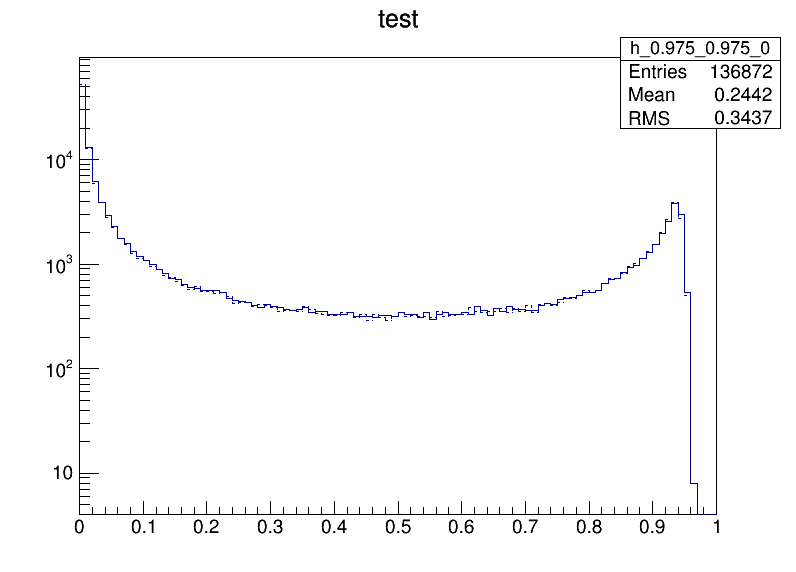

In [37]:
getHist(.975,.975,0).Draw()
getHist(1.,1.,0).SetLineStyle(ROOT.kDashed)
getHist(1.,1.,0).Draw('same')
c1.SetLogy()
c1

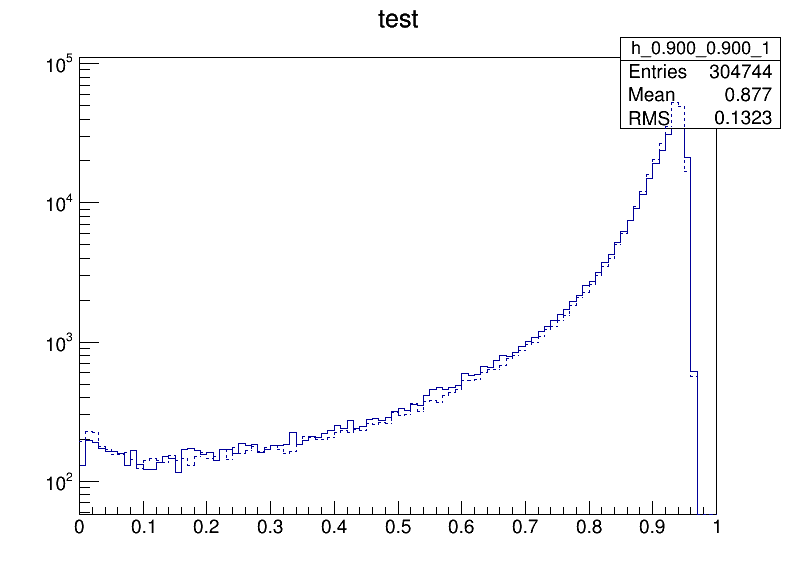

In [38]:
getHist(.9,.9,1).Draw()
getHist(1.,1.,1).SetLineStyle(ROOT.kDashed)
getHist(1.,1.,1).Draw('same')
c1

In [75]:
sOverBTemp = getHist(1.,1.,1)
bkgTemp = getHist(1.,1.,0)
sOverBTemp.Divide(bkgTemp)

True

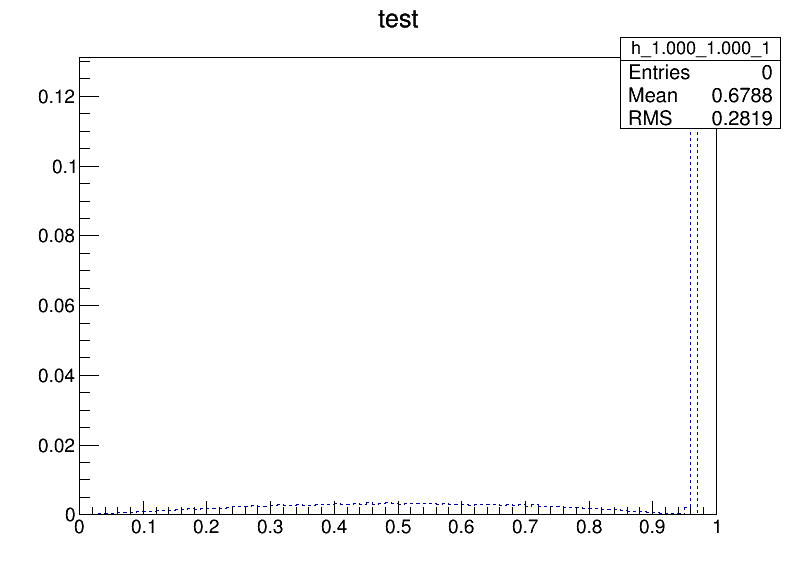

In [77]:
sOverBTemp.Draw()
c1